In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Mounted at /content/drive/


For basic understanding of LSTM i have referred to this video https://www.youtube.com/watch?v=LfnrRPFhkuY

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
column_names = ["target", "id", "date", "flag", "user", "text"]

texts_df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',encoding='latin-1', names=column_names)
texts_df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
texts_df = texts_df[['target','text']]
texts_df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


Only target(negative,neutral,positive) and texts are needed to predict the sentiments

In [ ]:
unique_targets = texts_df['target'].unique()
unique_targets

array([0, 4])

There are only negative(0) and positive(4) tweets in the dataset.

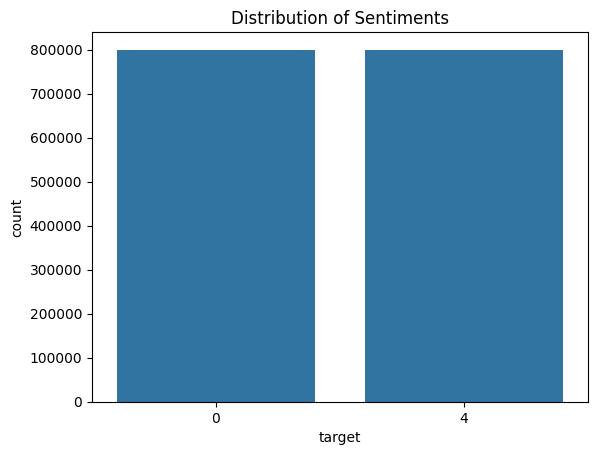

In [ ]:
sns.countplot(x='target', data=texts_df)
plt.title('Distribution of Sentiments')
plt.show()

Tweets are distributed uniformly among negative(0) and positive(4) tweets.

In [ ]:
texts_df['target'] = texts_df['target'].replace({0: 0, 4: 1})

<ipython-input-11-c5e88782a8a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['target'] = texts_df['target'].replace({0: 0, 4: 1})


negative comments have target value 0 and positive comments have target value 1

In [ ]:
texts_df['text'] = texts_df['text'].str.lower()

<ipython-input-12-9e06f2ddd0ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['text'] = texts_df['text'].str.lower()


all the tweets are converted to lower case to have uniformity in the dataset

In [ ]:
texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'@[^\s]+', '', x))
texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

<ipython-input-13-a9d76a25b2b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
<ipython-input-13-a9d76a25b2b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'@[^\s]+', '', x))
<ipython-input-13-a9d76a25b2b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'http\S+', '', x)): Removes URLs from each text.

texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'@[^\s]+', '', x)): Removes Twitter usernames (mentions) from each text.

texts_df['text'] = texts_df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)): Removes non-alphabetic characters from each text, keeping only letters and spaces.


In [ ]:
texts_df['text'] = texts_df['text'].apply(word_tokenize)

<ipython-input-14-445d8649a09d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['text'] = texts_df['text'].apply(word_tokenize)


This line breaks down each text in our data into separate words. It's like taking a sentence and splitting it into its building blocks. We use a tool called NLTK to do this. This step is crucial because it helps us handle the text more effectively and do all sorts of neat things with it, like counting words or understanding what the sentence is about.

In [ ]:
stopwords_list = set(stopwords.words('english'))
texts_df['text'] = texts_df['text'].apply(lambda x: [word for word in x if word not in stopwords_list])

<ipython-input-15-e38eb38a44fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['text'] = texts_df['text'].apply(lambda x: [word for word in x if word not in stopwords_list])


The first line sets up a collection of common English words that don't carry much meaning in text analysis, like "the," "is," and "and," using a tool called NLTK.

The second line does the heavy lifting. It goes through each text in our dataset and checks if any of these common, less meaningful words are present. If they are, it filters them out, leaving behind only the words that are likely to be more informative for our analysis.

I have referred to this video mainly for data pre processing
https://www.youtube.com/watch?v=oWo9SNcyxlI&t=826s

In [ ]:
texts_df['text'] = texts_df['text'].apply(lambda x: ' '.join(x))

<ipython-input-16-43116efb0536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts_df['text'] = texts_df['text'].apply(lambda x: ' '.join(x))


This line puts the words of each text back together into a sentence. We go through each text and use ' '.join(x) to merge the words. This step undoes the splitting we did earlier, making the text readable again after our analysis.

In [ ]:
texts_df

,target,text
0,0,awww thats bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save rest go bounds
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdbcom cool hear old walt interviews
1599997,1,ready mojo makeover ask details
1599998,1,happy th birthday boo alll time tupac amaru sh...


In [ ]:
# Tokenize and pad the sequences
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(texts_df['text'].values)
X = tokenizer.texts_to_sequences(texts_df['text'].values)
X = pad_sequences(X)

1. max_features = 2000: Sets the maximum number of unique words in the vocabulary.

2. tokenizer = Tokenizer(num_words=max_features, split=' '): This tool breaks our text into words and gives each word its own special number.

3. tokenizer.fit_on_texts(texts_df['text'].values): We're showing our tokenizer all the words in our text so it can learn and remember them.

4. X = tokenizer.texts_to_sequences(texts_df['text'].values): Now, we're translating our words into numbers so the computer can understand them better.

5. X = pad_sequences(X): Here, we're making sure all our coded messages (sequences) are the same length, like adding extra spaces to shorter messages so they all fit the same size box. This helps the computer work with them easily.

In [ ]:
# Target variable
Y = to_categorical(texts_df['target'].values)

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Defining LSTM model
embedding_dim = 128
lstm_out = 196

model = Sequential()

# Turns words into vectors
model.add(Embedding(max_features, embedding_dim, input_length=X.shape[1]))
from keras.layers import Conv1D, MaxPooling1D

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# Gives some words a break to prevent overfitting
model.add(SpatialDropout1D(0.4))

# Remember important stuff from past words
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))

# Judges the sentiment based on all the information
model.add(Dense(2, activation='sigmoid'))

Instead of what was done in the LSTM analysis, what we have done is add a Convolutional 1-Dimensional Layer with 64 filters. We also add a maxpooling layer after this. This is the singular basic change made between the LSTM analysis and this new model which attempts to combine the powers of both. The Attempt here is to extract patterns from the text data and then retaining the most important features(patterns) before moving on to the LSTM analysis which will then do sequential processing.


---



In [ ]:
# Model compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Model training
lstm_senti = model.fit(X_train, Y_train, epochs=2, batch_size=32, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/2
40000/40000 [==============================] - 1308s 33ms/step - loss: 0.4899 - accuracy: 0.7617 - val_loss: 0.4753 - val_accuracy: 0.7706
Epoch 2/2
40000/40000 [==============================] - 1296s 32ms/step - loss: 0.4770 - accuracy: 0.7699 - val_loss: 0.4714 - val_accuracy: 0.7725


In [ ]:
score, acc = model.evaluate(X_test, Y_test, verbose=2)
print("Test Score:", score)
print("Test Accuracy:", acc)

10000/10000 - 93s - loss: 0.4642 - accuracy: 0.7757 - 93s/epoch - 9ms/step
Test Score: 0.46419307589530945
Test Accuracy: 0.7756624817848206


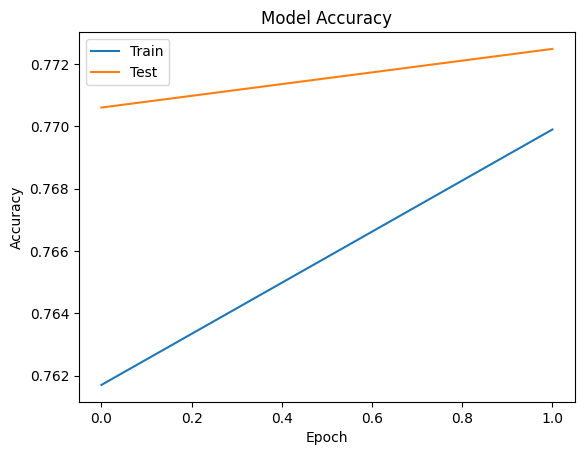

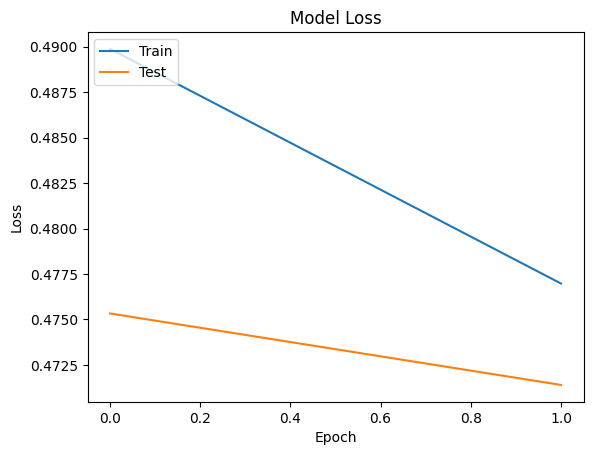

In [ ]:

# Plot accuracy vs epoch
plt.plot(lstm_senti.history['accuracy'])
plt.plot(lstm_senti.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss vs epoch
plt.plot(lstm_senti.history['loss'])
plt.plot(lstm_senti.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

I have used Chatgpt to for getting plots

10000/10000 [==============================] - 62s 6ms/step


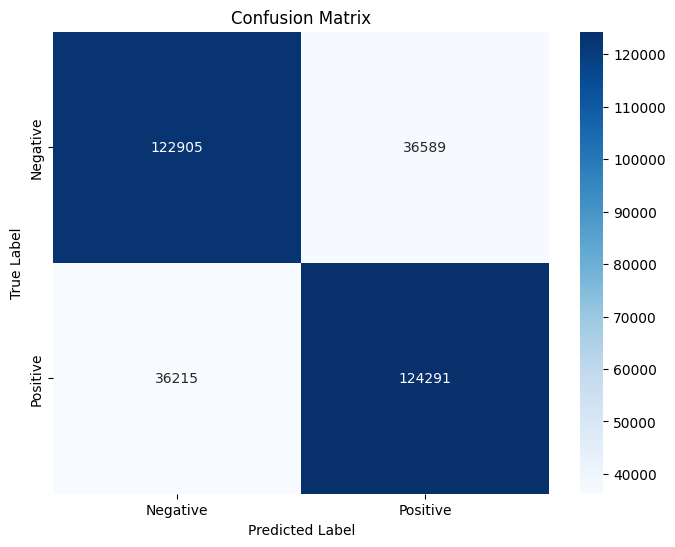

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the sentiment labels for the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

I have used Chatgpt to get confusion matrix

Additional references that I have gone through are https://www.youtube.com/watch?v=e0WW5w13V64

I have used chatGPT for debugging.

